# CMD using photutils
### Michael Warrener

## Preliminaries

In [2]:
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
from astropy.table import Table
from photutils import DAOStarFinder, aperture_photometry, CircularAperture, CircularAnnulus
import numpy as np

import matplotlib.pyplot as plt

#these are helpful packages for plotting images.
#You do not need to use them
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
plt.rcParams['figure.figsize'] = [12,8]
!jupyter nbconvert --to html CMD_lab_part1.ipynb

[NbConvertApp] Converting notebook CMD_lab_part1.ipynb to html
[NbConvertApp] Writing 625652 bytes to CMD_lab_part1.html


## M36 Data

### Open the data and find the stars

In [2]:
Bhdu=fits.open("../../../icema/Downloads/M36_Ba.fits")[0]
Bdata=np.array(Bhdu.data,dtype=np.int32)

Bmean, Bmedian, Bstd = sigma_clipped_stats(Bdata, sigma=3.0) #get mean, median, and std after sigma-clipping 
print((Bmean, Bmedian, Bstd))    

#use DAOStarFinder to find stars given the FWHM of the Gaussian kernel and the detection threshold for stars
Bdaofind = DAOStarFinder(fwhm=3.0, threshold=5.*Bstd)
Bsources = Bdaofind(Bdata - Bmedian) #extract sources from the bkg-subtracted data
Bmag=Bsources['mag']

(510.5124555265655, 510.0, 5.852104496577158)


In [3]:
Vhdu=fits.open("../../../icema/Downloads/M36_Va.fits")[0]
Vdata=np.array(Vhdu.data,dtype=np.int32)

Vmean, Vmedian, Vstd = sigma_clipped_stats(Vdata, sigma=3.0)  
print((Vmean, Vmedian, Vstd))    
Vdaofind = DAOStarFinder(fwhm=3.0, threshold=5.*Vstd)    
Vsources = Vdaofind(Vdata - Vmedian)    
Vmag=Vsources['mag']

(1090.392123136897, 1091.0, 10.928590964036953)


### check the alignment between the image frames

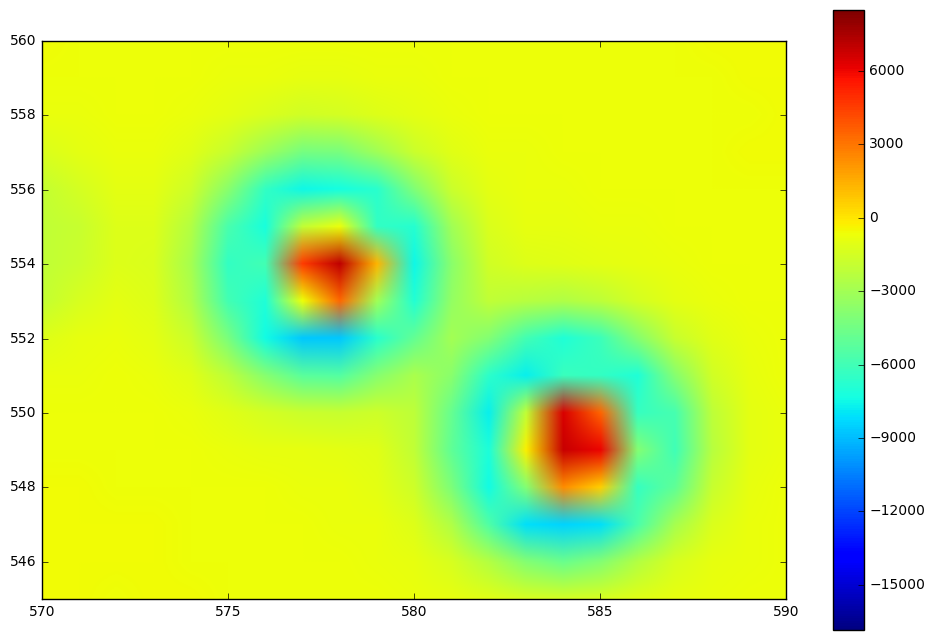

In [16]:
diff=Bdata-Vdata
plt.imshow(diff)
plt.xlim(570,590)
plt.ylim(545,560)
plt.colorbar()
plt.show()

We can see that the b-data seems to be brighter than the v-data and more centrally concentrated (better resolution). Additionally, the centers of the stars are aligned, which is what we want to check. Because B & V have different resolutions, we could use different aperture parameters, but (for now) we will use the same apertures.

### Match the stars

In [4]:
sources=Table(names=('x', 'y', 'b','v')) #initialize a table with 4 colomns: x-position, y-position, B-mag, and V-mag
dist_squared=0.5 #because the stars are aligned, we should not have any stars that have more than 1 pixel of miss-match
for vstar in Vsources: #find entries in the B and V tables for which the centroids are <dist pixel away from each other
    for bstar in Bsources:
        if (bstar['xcentroid']-vstar['xcentroid'])**2 + (bstar['ycentroid']-vstar['ycentroid'])**2<dist_squared:
            sources.add_row([bstar['xcentroid'],vstar['ycentroid'],bstar['mag'],vstar['mag']])
            break
print("len(sources)=%g"%len(sources))

len(sources)=793


### check star size

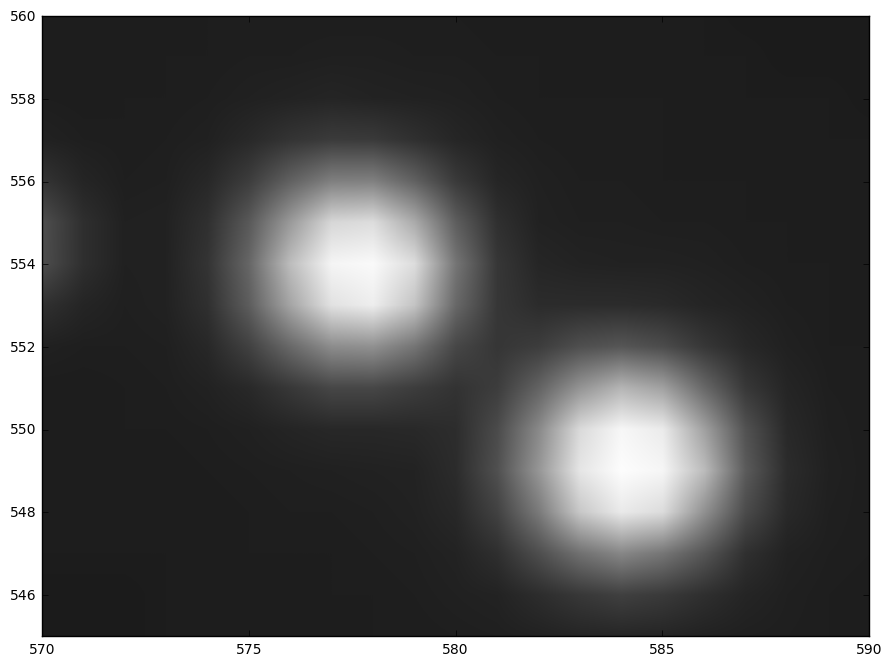

In [17]:
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(Bdata, cmap='Greys_r', origin='lower', norm=norm)
plt.xlim(570,590)
plt.ylim(545,560)
plt.show()

### Calculate the Photometry

In [8]:
#the biggest stars have radii around 5 or 6, so let's use 7 to be sure.
#Note that these numbers may not be the **most** optimal, but they work fairly well.
#For your star cluster, make sure to play with the aperture sizes to find what works best

positions = (sources['x'], sources['y'])
r_circ=7.0
r_ann1=10.0
r_ann2=12.0
circular_apertures = CircularAperture(positions, r=r_circ)
annulus_apertures = CircularAnnulus(positions, r_in=r_ann1, r_out=r_ann2)

#first calculate the photometry using circular apertures and a global background subtraction
Vphot_table = aperture_photometry(Vdata-Vmedian, circular_apertures)
v_circ=-2.5*np.log10(Vphot_table['aperture_sum'])
Bphot_table = aperture_photometry(Bdata-Bmedian, circular_apertures)
b_circ=-2.5*np.log10(Bphot_table['aperture_sum'])

#Now, calculate the photometry using both circles and annuli to get a local background subtraction
apers = [circular_apertures, annulus_apertures]
Vphot_table = aperture_photometry(Vdata, apers)
Bphot_table = aperture_photometry(Bdata, apers)

#calculate the V mags
Vbkg_mean = Vphot_table['aperture_sum_1'] / annulus_apertures.area()
Vbkg_sum = Vbkg_mean * apertures.area()
Vfinal_sum = Vphot_table['aperture_sum_0'] - Vbkg_sum
Vphot_table['residual_aperture_sum'] = Vfinal_sum
Vphot_table['residual_aperture_mag']=-2.5*np.log10(Vfinal_sum)
v_ann=Vphot_table['residual_aperture_mag']

#calculate the B mags
Bbkg_mean = Bphot_table['aperture_sum_1'] / annulus_apertures.area()
Bbkg_sum = Bbkg_mean * apertures.area()
Bfinal_sum = Bphot_table['aperture_sum_0'] - Bbkg_sum
Bphot_table['residual_aperture_sum'] = Bfinal_sum
Bphot_table['residual_aperture_mag']=-2.5*np.log10(Bfinal_sum)
b_ann=Bphot_table['residual_aperture_mag']

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: invalid value encountered in log10
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: RuntimeWarning: invalid value encountered in log10
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: RuntimeWarning: invalid value encountered in log10
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:37: RuntimeWarning: invalid value encountered in log10


Ignore the $\texttt{log10}$ errors above. When you do local background subtraction, sometimes you get light from a nearby star in your annulus. This makes the local background greater than the stellar flux, so the code thinks the star has a negative flux, and you cannot take the log of a negative number. These magnitudes are saved as $\texttt{nan}$ and are ignored for most purposes.

### Plot the CMD

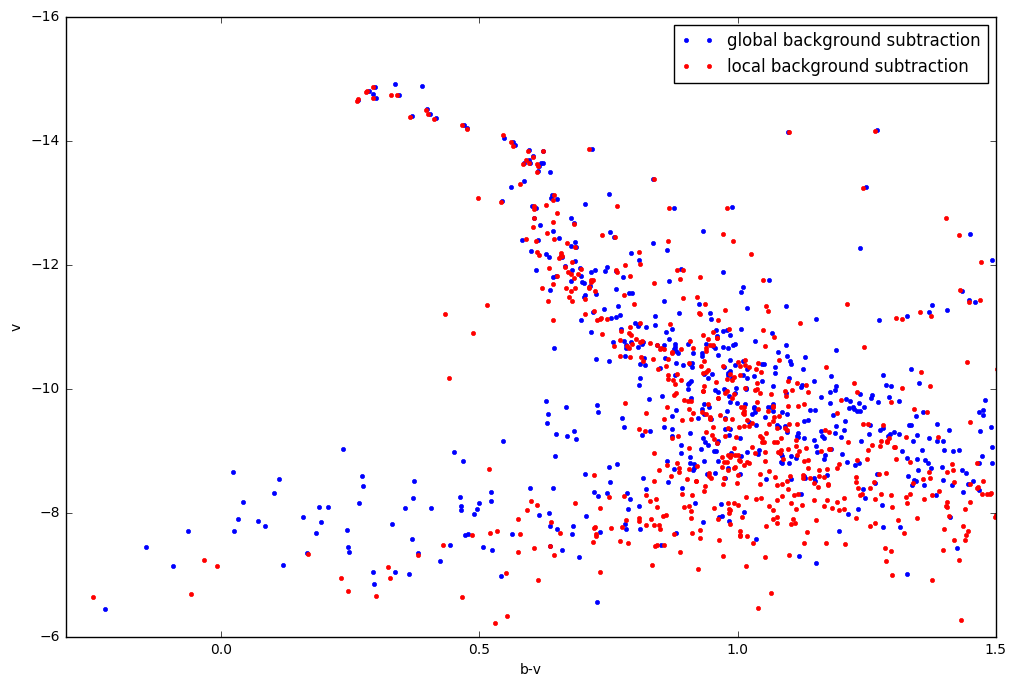

In [9]:
plt.plot(b_circ-v_circ,v_circ,'b.', label="global background subtraction")
plt.plot(b_ann-v_ann, v_ann,'r.',label='local background subtraction')
plt.xlabel('b-v')
plt.ylabel('v')
plt.legend()
plt.xlim(-0.3,1.5) #B-V color normal range
plt.ylim(-6,-16)
plt.show()